# INTRODUCTION

**Authors:**
- Raza Mehar
- Pujan Thapa
- Syed Najam Mehdi

**Last updated on:**
August 03, 2024

**Dataset:**

---


**What is PlantDoc?**

PlantDoc is a collection of images created to help with identifying plant diseases. Researchers at the Indian Institute of Technology put this dataset together.

**Details of the Dataset:**

- Number of Images: The dataset contains 2,569 pictures.
- Plant Species: These pictures show 13 different types of plants.
- Classes: There are 30 different categories in the dataset. These categories include both healthy plants and plants with various diseases.
- Labels: In total, there are 8,851 labels, which are used to identify different parts of the images, such as specific diseases or healthy areas.


# UTILITY

In [ ]:
#The ultralytics package is essential for leveraging YOLO (You Only Look Once) models in object detection tasks due to its simplicity and effectiveness.
!pip install ultralytics

#Roboflow provides tools for accessing and managing datasets. It is used to download the PlantDoc data.
!pip install roboflow

!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
# Install essential libraries and modules.
import os
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches # For drawing shapes on plots. We use it to draw bounding boxes on the images.
import tensorflow as tf
from scipy.stats import mannwhitneyu
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ultralytics import YOLO
from roboflow import Roboflow
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import hashlib
from google.colab import files
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn.decomposition import NMF
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from keras.preprocessing import image
from sklearn.decomposition import PCA
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict

In [ ]:
# Function to count the number of records in a TensorFlow dataset.
def count_dataset_record(tf_dataset):

    # Use the reduce method to iterate through the dataset and count the records.
    record_count = tf_dataset.reduce(0, lambda x, _: x + 1).numpy()

    return record_count

In [ ]:
# Define the feature description dictionary.
feature_description = {
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
}

In [ ]:
# Define a function to calculate cross-validated mean reconstruction error (MRE) to find the optimal value of n_components.
def cv_mre(data, n_components):

  # Fit NMF model with 4 components
  nmf = NMF(n_components=n_components, random_state=42)
  W = nmf.fit_transform(data)
  H = nmf.components_

  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  errors = []

  for train_index, test_index in kf.split(data):
      train_data, test_data = data[train_index], data[test_index]
      nmf = NMF(n_components=n_components, random_state=42)
      W_train = nmf.fit_transform(train_data)
      H = nmf.components_
      W_test = nmf.transform(test_data)
      reconstruction = np.dot(W_test, H)
      error = mean_squared_error(test_data, reconstruction)
      errors.append(error)

  mean_error = np.mean(errors)
  print(f'Cross-validated mean reconstruction error when n_components = {n_components}: {mean_error}')

In [ ]:
# Define a parsing function
def parse_example(example_proto):
    # Parse the input tf.train.Example proto using the feature description
    example = tf.io.parse_single_example(example_proto, feature_description)

    # Decode the image
    image = tf.image.decode_jpeg(example['image/encoded'])

    # Extract features
    image_format = example['image/format']
    width = example['image/width']
    height = example['image/height']
    filename = example['image/filename']

    class_text = tf.sparse.to_dense(example['image/object/class/text'], default_value='')

    xmin = tf.sparse.to_dense(example['image/object/bbox/xmin'], default_value=0.0)
    xmax = tf.sparse.to_dense(example['image/object/bbox/xmax'], default_value=0.0)
    ymin = tf.sparse.to_dense(example['image/object/bbox/ymin'], default_value=0.0)
    ymax = tf.sparse.to_dense(example['image/object/bbox/ymax'], default_value=0.0)

    # Combine the bounding box coordinates into a single tensor
    bbox = tf.stack([xmin, ymin, xmax, ymax], axis=-1)

    return image, image_format, width, height, filename, class_text, bbox

In [ ]:
#Function to extract features such as images, image_formats, widths, heights, filenames, class_texts, bboxes, mean_intensitie from TFRecords file.
def extract_features2(parsed_dataset):
    images, image_formats, widths, heights, filenames, class_texts, bboxes, mean_intensities = [], [], [], [], [], [], [], []

    for example in parsed_dataset:
        # Unpack the tuple assuming the order of elements in the tuple
        image, image_format, width, height, filename, class_text, bbox = example

        # Convert tensors to numpy arrays or decode strings as necessary
        images.append(image.numpy())
        image_formats.append(image_format.numpy().decode('utf-8'))
        widths.append(width.numpy())
        heights.append(height.numpy())
        filenames.append(filename.numpy().decode('utf-8'))
        class_texts.append([c.numpy().decode('utf-8') for c in class_text])
        bboxes.append(bbox.numpy())

        # Calculate mean pixel intensity
        mean_intensity = np.mean(image.numpy())
        mean_intensities.append(mean_intensity)

    return images, image_formats, widths, heights, filenames, class_texts, bboxes, mean_intensities

In [ ]:
# Function to extract features from the images using the base model.
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224)) # VGG16 expects an image of 224 x 224
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = base_model.predict(img_data)
    return features.flatten()

In [ ]:
# Function to read the label_map.pbtxt file (protobuf text file) that maps class labels to their corresponding integer IDs for use in TensorFlow object detection models.
def read_label_map(label_map_path):
    label_map = {}
    with open(label_map_path, 'r') as f:
        lines = f.readlines()

    id = None

    for line in lines:
        line = line.strip()
        if line.startswith("id:"):
            # Extracting numeric ID by splitting and cleaning the substring by removing the trailing comma
            id_str = line.split(":")[1].strip().rstrip(',')
            id = int(id_str)
        elif line.startswith("name:"):
            if id is not None:  # Ensure id has been initialized
                name = line.split(":")[1].strip().strip("'")
                label_map[id] = name
                id = None  # Reset id for next iteration
    return label_map

In [ ]:
# Function to find count of all files in a directory.
def count_files_in_directory(directory):
    # List all files in the directory
    files = os.listdir(directory)
    # Count the number of files
    file_count = len(files)
    return file_count

In [ ]:
# Function to generate shorter filenames.
def generate_short_identifier(image_file):
    hash_object = hashlib.md5(image_file.encode())

    # Return the first 8 characters of the hash
    return hash_object.hexdigest()[:8]

In [ ]:
def calculate_fuzzy_metrics(features, max_clusters=10, m=2.0, error=0.005, maxiter=1000, seed=42):
    fpcs = []
    pes = []
    xb_indices = []

    for n_clusters in range(2, max_clusters + 1):
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            features.T, n_clusters, m, error=error, maxiter=maxiter, seed=seed
        )

        # Fuzzy Partition Coefficient
        fpcs.append(fpc)

        # Partition Entropy
        pe = -np.sum(u * np.log(u)) / features.shape[1]
        pes.append(pe)

        # Xie-Beni Index
        N = features.shape[1]
        cluster_distances = np.linalg.norm(features[:, :, np.newaxis] - cntr.T[np.newaxis, :, :], axis=1)
        min_dist = np.min(cluster_distances[cluster_distances != 0])
        xb_index = np.sum((u**2).T * (cluster_distances**2)) / (N * min_dist**2)
        xb_indices.append(xb_index)

    return fpcs, pes, xb_indices

In [ ]:
# Define a function that shows the images that are most strongly associated with each NMF component.
def plot_component_images(component_index, num_images=5):
    component_weights = W[:, component_index]

    # Sort the component weights to find the top 5 image indices that have the highest weights for the given component.
    top_indices = component_weights.argsort()[-num_images:][::-1]

    plt.figure(figsize=(12, 6))
    for i, index in enumerate(top_indices):
        img = image.load_img(all_image_paths[index], target_size=(224, 224))
        img_array = image.img_to_array(img)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array.astype('uint8'))
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f"Top {num_images} Images for Component {component_index}", y=0.3)

In [ ]:
# Load images to display
def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    return image.img_to_array(img) / 255.0  # Normalize image data

# Display images from each cluster
def display_cluster_images(cluster_indices, image_paths, num_images=5):
    for cluster_id in np.unique(cluster_indices):
        plt.figure(figsize=(12, 6))
        cluster_images = np.where(cluster_indices == cluster_id)[0]
        selected_images = np.random.choice(cluster_images, num_images, replace=False)
        for i, img_idx in enumerate(selected_images):
            img = load_image(image_paths[img_idx])
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.suptitle(f'Top 5 Images for Cluster {cluster_id}', y=0.3)

# DATA DOWNLOAD AND LOADING

**Downloading TFRecords**

The data is stored in TFRecord format, which is a binary file format designed for efficient data storage in TensorFlow. TFRecord files are commonly used to store large datasets in a compact manner, optimizing data reading and processing speeds during machine learning operations.

In [ ]:
# Download the TFRecord file directly from the source.
url = 'https://public.roboflow.com/ds/53EHK1GDAk?key=VJlibHly03'

response = requests.get(url)

**Downloading Data in the Yolov8 Format**

In [ ]:
# Initialize Roboflow Client with API key.
rf = Roboflow(api_key="Ss5w6YAybpdtFMDWh7hO")

# Access the relevant workspace and project.
project = rf.workspace("joseph-nelson").project("plantdoc")

# Access project version.
version = project.version(1)

# Download the dataset.
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.71, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to PlantDoc-1 in yolov8:: 100%|██████████| 5143/5143 [00:00<00:00, 7368.92it/s]


In [ ]:
# Specify the path where the compressed file will be saved.
compressed_file = '/content/compressed_file.zip'

# Write the downloaded content to the file.
with open(compressed_file, 'wb') as f:
    f.write(response.content)

print("Downloaded content has been successfully written to a file.")
print("-----------------------------------------------------------\n")

# Unzip the compressed file.
!unzip compressed_file.zip

print("Compressed file has been successfully unzipped.")
print("-----------------------------------------------------------")

Downloaded content has been successfully written to a file.
-----------------------------------------------------------

Archive:  compressed_file.zip
 extracting: test/leaves.tfrecord    
 extracting: train/leaves.tfrecord   
 extracting: test/leaves_label_map.pbtxt  
 extracting: train/leaves_label_map.pbtxt  
 extracting: README.roboflow.txt     
 extracting: README.dataset.txt      
Compressed file has been successfully unzipped.
-----------------------------------------------------------


# DATA REVIEW

**Creating TFRecord datasets and Parsing each Record**

In [ ]:
# Specify paths to the training and test TFRecord files.
train_tfrecord = '/content/train/leaves.tfrecord'
test_tfrecord = '/content/test/leaves.tfrecord'

# Create TFRecord datasets for the training and test data.
raw_train_dataset = tf.data.TFRecordDataset(train_tfrecord)
raw_test_dataset = tf.data.TFRecordDataset(test_tfrecord)

# Map the parsing function to each record
parsed_train_dataset = raw_train_dataset.map(parse_example)
parsed_test_dataset = raw_test_dataset.map(parse_example)

print("TFRecords datasets for training and test data have been successfully created and parsed.")
print("--------------------------------------------------------------------------")

TFRecords datasets for training and test data have been successfully created and parsed.
--------------------------------------------------------------------------


**Displaying the Number of Records in the Training and Test Datasets**

In [ ]:
num_train_records = count_dataset_record(raw_train_dataset)
num_test_records = count_dataset_record(raw_test_dataset)

print('Number of records in the training dataset:', num_train_records)
print('Number of records in the test dataset:',num_test_records)
print('-------------------------------------------------')
total_records = num_train_records + num_test_records
print('Total records:',total_records)

train_percent = (num_train_records/total_records) * 100
test_percent = (num_test_records/total_records) * 100

print(f'\nThe split is {train_percent:.0f}% training and {test_percent:.0f}% test.')

Number of records in the training dataset: 2330
Number of records in the test dataset: 239
-------------------------------------------------
Total records: 2569

The split is 91% training and 9% test.


In [ ]:
# Extract features from the training dataset
train_images, train_image_formats, train_widths, train_heights, train_filenames, train_class_texts, train_bboxes, train_mean_intensities = extract_features2(parsed_train_dataset)

# Extract features from the test dataset
test_images, test_image_formats, test_widths, test_heights, test_filenames, test_class_texts, test_bboxes, test_mean_intensities = extract_features2(parsed_test_dataset)

**Displaying Images with Bounding Boxes and Their Classes**

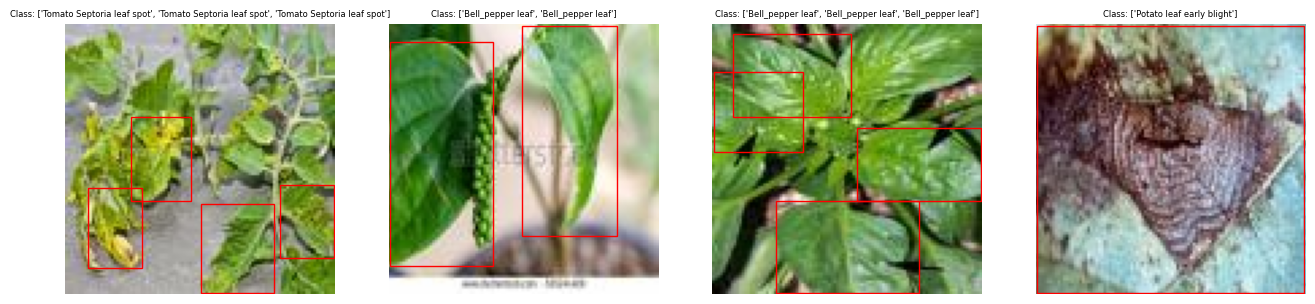

In [ ]:
# Set the number of images to display
num_example = 4

fig, ax = plt.subplots(1, num_example, figsize=(16, 4))

for i in range(num_example):
    title = f'Class: {train_class_texts[i][0:num_example-1]}'

    ax[i].imshow(train_images[i])
    ax[i].axis('off')
    ax[i].set_title(title, fontsize=6)

    # Draw bounding boxes on the images.
    for bbox in train_bboxes[i]:
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin * train_widths[i], ymin * train_heights[i]), (xmax - xmin) * train_widths[i], (ymax - ymin) * train_heights[i], linewidth=1, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)

plt.show()

**Displaying the Unique Classes**

In [ ]:
from collections import Counter

# Flatten the list of lists for classes
flattened_classes = [item for sublist in train_class_texts for item in sublist]

# Count occurrences of each class
class_counts = Counter(flattened_classes)

# Select unique classes
unique_classes = set(flattened_classes)

print(f'There are {len(unique_classes)} unique classes.\n')

# Print the unique classes and their counts
for cls, count in class_counts.items():
    print(f'{cls}: {count}')


There are 30 unique classes.

Tomato Septoria leaf spot: 402
Bell_pepper leaf: 312
Potato leaf early blight: 301
grape leaf black rot: 125
Corn rust leaf: 117
Corn leaf blight: 356
Tomato leaf yellow virus: 759
Strawberry leaf: 462
Blueberry leaf: 816
Tomato mold leaf: 279
Raspberry leaf: 539
Tomato leaf late blight: 204
Tomato leaf bacterial spot: 266
Soyabean leaf: 246
Tomato Early blight leaf: 193
Corn Gray leaf spot: 72
Squash Powdery mildew leaf: 248
Apple leaf: 237
Apple rust leaf: 167
Cherry leaf: 220
Tomato leaf mosaic virus: 225
Bell_pepper leaf spot: 248
Peach leaf: 604
Potato leaf late blight: 235
Tomato leaf: 373
grape leaf: 205
Apple Scab Leaf: 158
Tomato two spotted spider mites leaf: 2
Soybean leaf: 15
Potato leaf: 11


**Observation:** We can see that diseased images have the following terms in their classes: [blight, rust, spot, rot, mite, bacteria, mildew, virus, scab, squash, powdery]

**Separating Data into Healthy and Diseases Samples**

Number of healthy samples: 851
Number of diseased samples: 1479


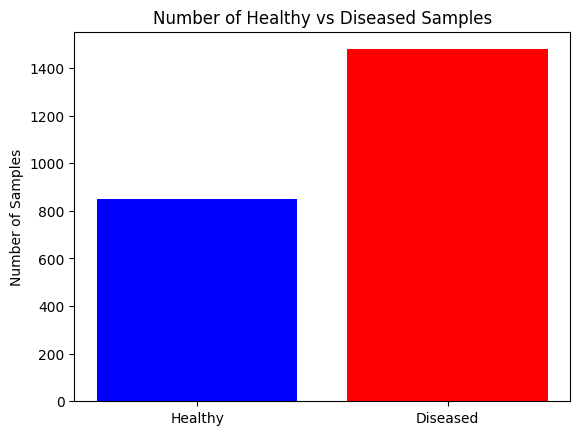

In [ ]:
# List of plant issues (diseases).
plant_issues = ["blight", "rust", "spot", "mite", "rot", "bacteria", "mildew", "virus", "scab", "spider", "squash", "powdery"]

# Initialize lists to store intensities for healthy and diseased images.
healthy_intensities = []
diseased_intensities = []

# Iterate through each image's class texts.
for i, class_texts in enumerate(train_class_texts):
    is_diseased = False

    # Check if any disease keyword is present in the class texts.
    for class_text in class_texts:
        for issue in plant_issues:
            if issue in class_text.lower():
                is_diseased = True
                break
        if is_diseased:
            break

    # Append mean intensity to the corresponding list based on healthy or diseased status.
    if is_diseased:
        diseased_intensities.append(train_mean_intensities[i])
    else:
        healthy_intensities.append(train_mean_intensities[i])

num_healthy_samples = len(healthy_intensities)
num_diseased_samples = len(diseased_intensities)
print('Number of healthy samples:', num_healthy_samples)
print('Number of diseased samples:', num_diseased_samples)

labels = ['Healthy', 'Diseased']
sample_counts = [num_healthy_samples, num_diseased_samples]

fig, ax = plt.subplots()
bars = ax.bar(labels, sample_counts, color=['blue', 'red'])

ax.set_ylabel('Number of Samples')
ax.set_title('Number of Healthy vs Diseased Samples')
plt.show()

**Displaying Histograms of the Width and Height of Images**

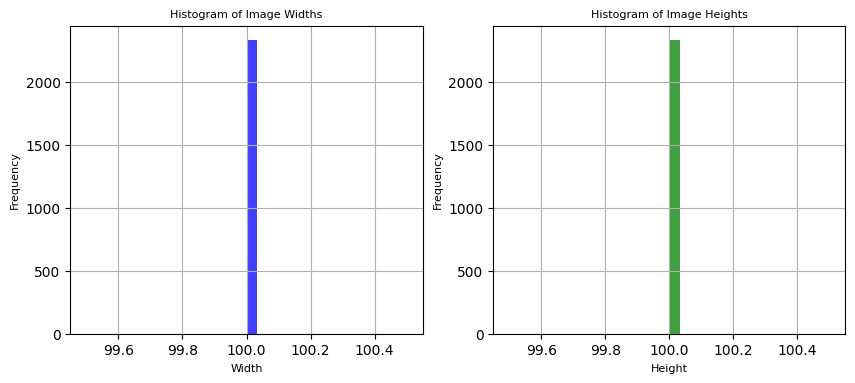

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot histogram of image widths.
ax[0].hist(train_widths, bins=30, alpha=0.75, color='b')
ax[0].set_xlabel('Width', fontsize=8)
ax[0].set_ylabel('Frequency', fontsize=8)
ax[0].set_title('Histogram of Image Widths', fontsize=8)
ax[0].grid(True)

# Plot histogram of image heights.
ax[1].hist(train_heights, bins=30, alpha=0.75, color='g')
ax[1].set_xlabel('Height', fontsize=8)
ax[1].set_ylabel('Frequency', fontsize=8)
ax[1].set_title('Histogram of Image Heights', fontsize=8)
ax[1].grid(True)

**Observation:** The histograms of width and height indicate that the dimensions of the images are consistently 416 x 416 pixels.

**Displaying the Image Formats**

In [ ]:
train_image_formats[0:5]

['jpeg', 'jpeg', 'jpeg', 'jpeg', 'jpeg']

**Mapping the Classes**

In [ ]:
label_map_path = '/content/train/leaves_label_map.pbtxt'
label_map = read_label_map(label_map_path)

# Ensure all 30 classes are loaded.
expected_num_classes = 30
actual_num_classes = len(label_map)

if actual_num_classes < expected_num_classes:
    print(f"Warning: Only {actual_num_classes} classes loaded from {label_map_path}. Expected {expected_num_classes}.")
elif actual_num_classes > expected_num_classes:
    print(f"Warning: Loaded {actual_num_classes} classes from {label_map_path}. Expected {expected_num_classes}.")
else:
    print(f"Successfully loaded {actual_num_classes} classes from {label_map_path}.")

# Print all class names and IDs.
for id, name in label_map.items():
    print(f'ID: {id} | Name: {name}')

ID: 1 | Name: "Apple leaf",
ID: 2 | Name: "Apple rust leaf",
ID: 3 | Name: "Bell_pepper leaf",
ID: 4 | Name: "Bell_pepper leaf spot",
ID: 5 | Name: "Blueberry leaf",
ID: 6 | Name: "Cherry leaf",
ID: 7 | Name: "Corn Gray leaf spot",
ID: 8 | Name: "Corn leaf blight",
ID: 9 | Name: "Corn rust leaf",
ID: 10 | Name: "Peach leaf",
ID: 11 | Name: "Potato leaf",
ID: 12 | Name: "Potato leaf early blight",
ID: 13 | Name: "Potato leaf late blight",
ID: 14 | Name: "Raspberry leaf",
ID: 15 | Name: "Soyabean leaf",
ID: 16 | Name: "Soybean leaf",
ID: 17 | Name: "Squash Powdery mildew leaf",
ID: 18 | Name: "Strawberry leaf",
ID: 19 | Name: "Tomato Early blight leaf",
ID: 20 | Name: "Tomato Septoria leaf spot",
ID: 21 | Name: "Tomato leaf",
ID: 22 | Name: "Tomato leaf bacterial spot",
ID: 23 | Name: "Tomato leaf late blight",
ID: 24 | Name: "Tomato leaf mosaic virus",
ID: 25 | Name: "Tomato leaf yellow virus",
ID: 26 | Name: "Tomato mold leaf",
ID: 27 | Name: "Tomato two spotted spider mites leaf",
ID:

In [ ]:
class_map = {
    "Apple Scab Leaf": 0,
    "Apple leaf": 1,
    "Apple rust leaf": 2,
    "Bell_pepper leaf": 3,
    "Bell_pepper leaf spot": 4,
    "Blueberry leaf": 5,
    "Cherry leaf": 6,
    "Corn Gray leaf spot": 7,
    "Corn leaf blight": 8,
    "Corn rust leaf": 9,
    "Peach leaf": 10,
    "Potato leaf": 11,
    "Potato leaf early blight": 12,
    "Potato leaf late blight": 13,
    "Raspberry leaf": 14,
    "Soyabean leaf": 15,
    "Soybean leaf": 16,
    "Squash Powdery mildew leaf": 17,
    "Strawberry leaf": 18,
    "Tomato Early blight leaf": 19,
    "Tomato Septoria leaf spot": 20,
    "Tomato leaf": 21,
    "Tomato leaf bacterial spot": 22,
    "Tomato leaf late blight": 23,
    "Tomato leaf mosaic virus": 24,
    "Tomato leaf yellow virus": 25,
    "Tomato mold leaf": 26,
    "Tomato two spotted spider mites leaf": 27,
    "grape leaf": 28,
    "grape leaf black rot": 29
}

# STATISTICAL TESTING

**Hypothesis Testing**

*Null Hypothesis (H₀):* This hypothesis assumes that there is no significant difference between the groups.

- H₀: The mean pixel intensity in diseased plants is equal to the mean pixel intensity in healthy plants.

*Alternative Hypothesis (H₁):* This hypothesis suggests that there is a significant difference between the groups.

- H₁: The mean pixel intensity in diseased plants is different from the mean pixel intensity in healthy plants.

**Performing Hypothesis Testing**

In [ ]:
stat, p_value = mannwhitneyu(healthy_intensities, diseased_intensities, alternative='two-sided')

print('Statistic:', stat)
print('P-value:', p_value)

Statistic: 788808.0
P-value: 1.976943963879713e-24


**Interpreting the Results**

In [ ]:
# Set the significance level.
alpha = 0.05

if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in mean pixel intensity between diseased and healthy plants.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in mean pixel intensity between diseased and healthy plants.')

Reject the null hypothesis: There is a significant difference in mean pixel intensity between diseased and healthy plants.


In [ ]:
# Define the content of data.yaml.
yaml_content = """
train: /content/output_dir/train/images  # Directory containing training images
val: /content/output_dir/test/images  # Directory containing test images
nc: 30  # Number of classes

names:
  - "Apple Scab Leaf"
  - "Apple leaf"
  - "Apple rust leaf"
  - "Bell_pepper leaf"
  - "Bell_pepper leaf spot"
  - "Blueberry leaf"
  - "Cherry leaf"
  - "Corn Gray leaf spot"
  - "Corn leaf blight"
  - "Corn rust leaf"
  - "Peach leaf"
  - "Potato leaf"
  - "Potato leaf early blight"
  - "Potato leaf late blight"
  - "Raspberry leaf"
  - "Soyabean leaf"
  - "Soybean leaf"
  - "Squash Powdery mildew leaf"
  - "Strawberry leaf"
  - "Tomato Early blight leaf"
  - "Tomato Septoria leaf spot"
  - "Tomato leaf"
  - "Tomato leaf bacterial spot"
  - "Tomato leaf late blight"
  - "Tomato leaf mosaic virus"
  - "Tomato leaf yellow virus"
  - "Tomato mold leaf"
  - "Tomato two spotted spider mites leaf"
  - "grape leaf"
  - "grape leaf black rot"
"""

# Write yaml_content to data.yaml.
with open('/content/data.yaml', 'w') as f:
    f.write(yaml_content)

In [ ]:
# Define paths to the images and labels directories.
images_dir = '/content/PlantDoc-1/train/images'
labels_dir = '/content/PlantDoc-1/train/labels'

# Get the list of images in the images directory.
image_files = os.listdir(images_dir)

In [ ]:
print('Count of images:', count_files_in_directory(images_dir))
print('Count of labels:', count_files_in_directory(labels_dir))

Count of images: 2328
Count of labels: 2328


# DATA RESIZE, NORMALIZATION AND FEATURE EXTRACTION

We will use a pretrained model VGG16 to extract features from the images.

In [ ]:
# Load pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Directory containing all images.
all_image_paths = '/content/PlantDoc-1/train/images/'
all_image_paths = [os.path.join(all_image_paths, fname) for fname in os.listdir(all_image_paths) if fname.endswith('.jpg')]

# Extract features for all images.
# 'all_features' contains flattened arrays.
all_features = np.array([extract_features(img_path) for img_path in all_image_paths])

# NONNEGATIVE MATRIX FACTORIZATION (NMF)

NMF breaks down data (images) into parts that only use positive values to find hidden patterns and common features in the images, like shapes or colors, that often appear together.

**Finding the Optimal Number of Components**

Maximum number of iterations 200 reached. Increase it to improve convergence.


Text(0.5, 1.0, 'Elbow Curve to Select the Optimal Number of Components')

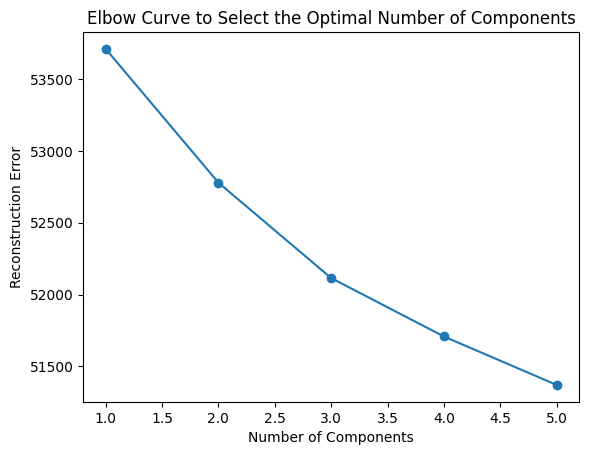

In [ ]:
n_components_range = range(1, 6)

reconstruction_errors = []

for n in n_components_range:
    nmf = NMF(n_components=n, random_state=42)
    W = nmf.fit_transform(all_features)
    H = nmf.components_

    # Calculate the reconstruction error.
    reconstruction_error = nmf.reconstruction_err_
    reconstruction_errors.append(reconstruction_error)

plt.plot(n_components_range, reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Elbow Curve to Select the Optimal Number of Components')

**Observations:** The reconstruction error decreases more slowly starting from 𝑛 = 3 n=3 and 𝑛 = 4 =4. We will calculate the mean reconstruction error for both to select the optimal value of n_components.

**Calculating the Mean Reconstruction Error for n = 3 and n = 4**

In [ ]:
cv_mre(all_features, 3)
cv_mre(all_features, 4)

Cross-validated mean reconstruction error when n_components = 3: 46.7470588684082
Cross-validated mean reconstruction error when n_components = 4: 46.117767333984375


**Observations:** The cross-validated mean reconstruction error (MRE) for n_components = 4 is slightly lower than the MRE for n_components = 3. Therefore, we will select 4 as the optimal number of components.

**Applying NMF**

In [ ]:
# Define the optinal number of components
n_components = 4

# Apply NMF
nmf = NMF(n_components=n_components, random_state=42)

# W to contain the transformed features.
W = nmf.fit_transform(all_features)

# H contain the components.
H = nmf.components_

In [ ]:
for i, component in enumerate(H):
    print(f"Component {i}:")
    print(component)

Component 0:
[     1.1574      0.8042      1.2042 ...     0.70972      1.6511      1.4231]
Component 1:
[     2.5256     0.47669      11.573 ...      0.5656      6.5544      1.0011]
Component 2:
[   0.031902           0           0 ...    0.022971       1.087           0]
Component 3:
[          0           0           0 ...           0     0.56231           0]


**Visualizing the Components**

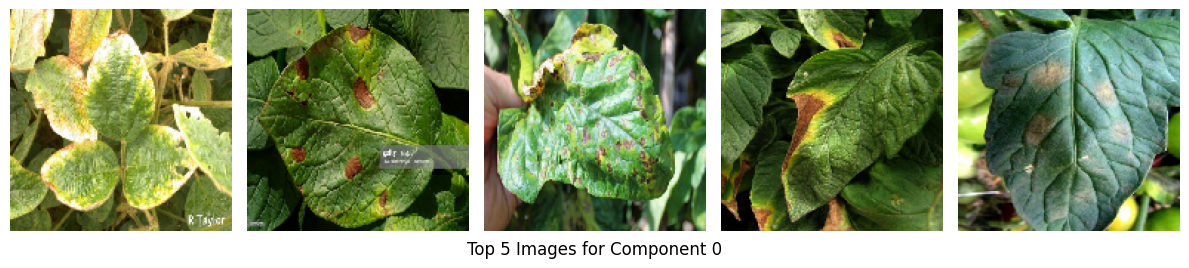

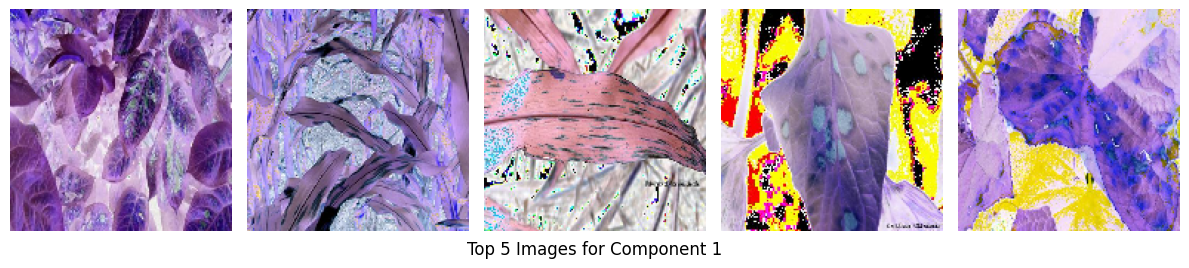

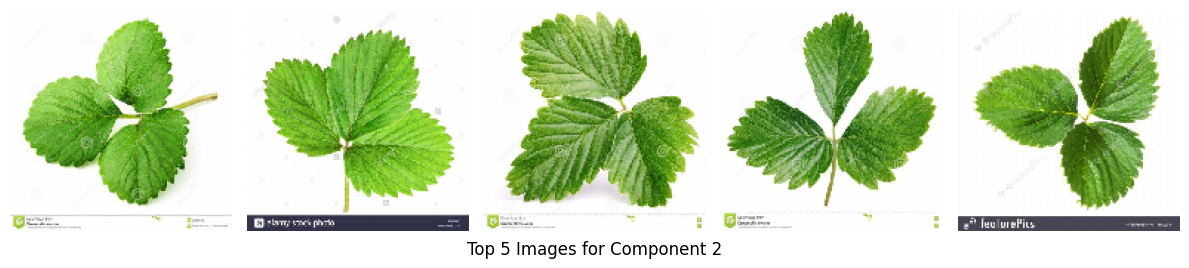

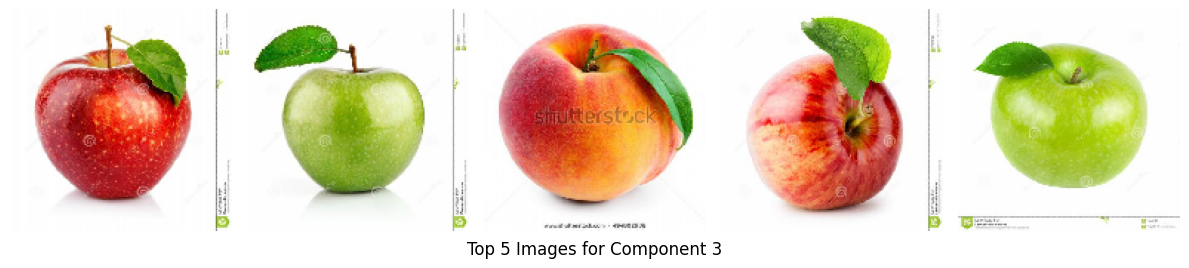

In [ ]:
# Plot images for each component.
for i in range(n_components):
    plot_component_images(i)

**Observation and Actions:**

Component 0: Plant Disease Focus.

Action: Ensure the dataset is balanced using resampling techniques and addressing unrepresented classes.


Component 1: Abstract Focus.

Action: Add color variations to by adjusting contrasts, brightness, and hue.


Component 2: Strawberry Leaves Focus.

Action: Add more training examples using geometric transformations like flipping, rotating, and cropping.


Component 3: Fruit Variety Focus.

Action: Collect a variety of images from the 13 species of plants.

# FUZZY CLUSTERING

**Finding the Optimal Number of Clusters**

We will compute three metrices to find the optimal number of clusters:

- The FPC is a measure of the degree of fuzziness in the clustering.
- Partition entropy measures the fuzziness of the partitioning.
- The Xie-Beni index is a validity measure that takes into account the compactness and separation of clusters

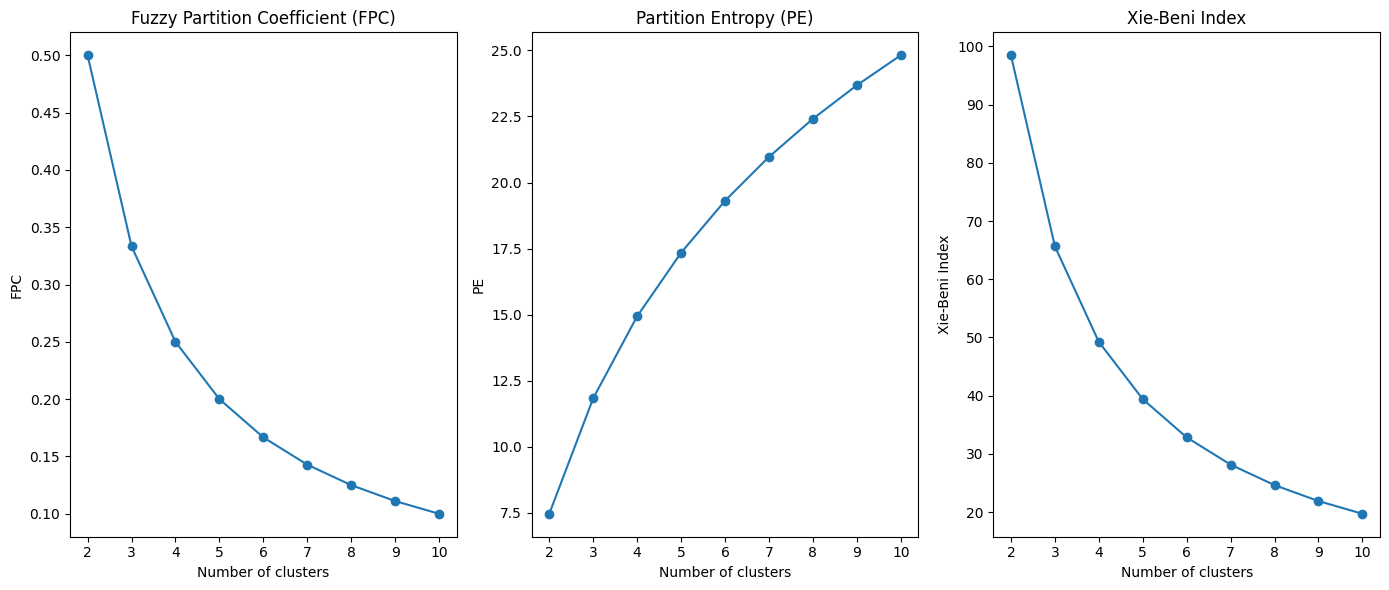

In [60]:
fpcs, pes, xb_indices = calculate_fuzzy_metrics(all_features.T)

clusters = range(2, len(fpcs) + 2)

plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(clusters, fpcs, marker='o')
plt.title('Fuzzy Partition Coefficient (FPC)')
plt.xlabel('Number of clusters')
plt.ylabel('FPC')

plt.subplot(1, 3, 2)
plt.plot(clusters, pes, marker='o')
plt.title('Partition Entropy (PE)')
plt.xlabel('Number of clusters')
plt.ylabel('PE')

plt.subplot(1, 3, 3)
plt.plot(clusters, xb_indices, marker='o')
plt.title('Xie-Beni Index')
plt.xlabel('Number of clusters')
plt.ylabel('Xie-Beni Index')

**Observations:**

- Fuzzy Partition Coefficient (FPC): Suggests 3 clusters are optimal, as FPC drops significantly up to 4 clusters.
- Partition Entropy (PE): Indicates 3 or 4 clusters are optimal, as PE increases sharply up to 4 clusters.
- Xie-Beni Index: Recommends 3, as the Xie-Beni Index decreases sharply up to 4 clusters.

Hence the optimal number of clusters = 3

**Performing Fuzzy C-Means Clustering**

In [61]:
n_clusters = 3

# Set a random seed for reproducibility.
random_seed = 42

# Initialize Fuzzy C-Means with Euclidean distance.

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    all_features.T,  # Transpose to match expected input shape.
    c=n_clusters,  # Number of clusters.
    m=1.5,  # Fuzziness parameter.
    error=0.005,  # Convergence criterion.
    maxiter=1000,  # Maximum number of iterations.
    seed=random_seed
)

In [62]:
# Get cluster centers and membership values (the degree of membership for each image in each cluster).
cluster_centers = cntr
membership_values = u

In [63]:
# Get the index of the cluster with the highest membership for each image
cluster_assignments = np.argmax(membership_values, axis=0)

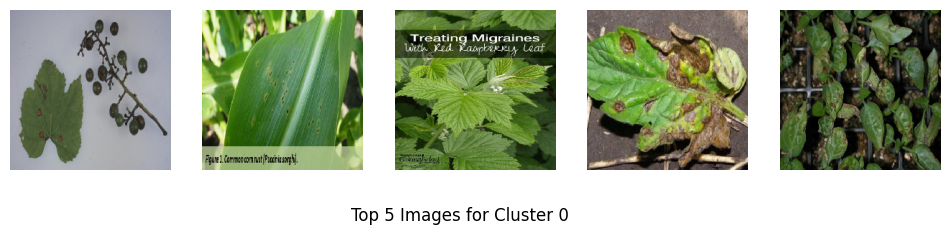

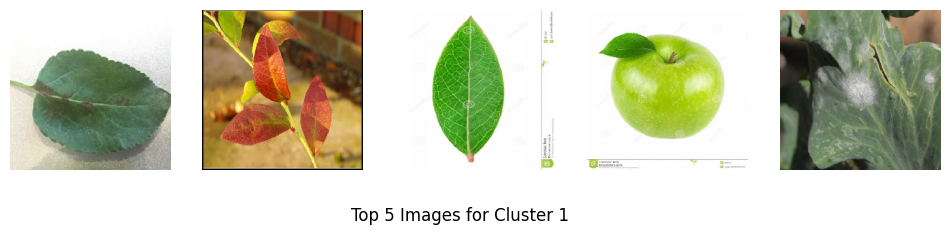

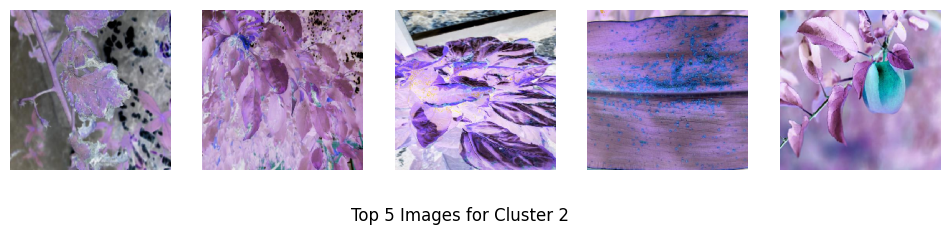

In [65]:
# Display images.
display_cluster_images(cluster_assignments, all_image_paths)

**Observation and Actions:**

Cluster 0: Plant Disease Focus.

Action: Ensure the dataset is balanced using resampling techniques and addressing unrepresented classes.

Cluster 1: Plant Morphology Focus.

Action: Introduce random noise such as Gaussian noise to simulate real-world image imperfections.

Cluster 2: Abstract Focus.

Action: Add color variations to by adjusting contrasts, brightness, and hue.

BEfore augmentaiton, handle unrep classes and then apply data aug

# HANDLING CLASS IMABALANCE AND UNREPRESENTED CLASSES

# DATA AUGMENTATION

In [ ]:
# Define the sequence of augmentations.
seq = iaa.Sequential([

    # Adjust contrast of the image randomly between 0.5 and 1.5 times the original contrast.
    iaa.ContrastNormalization((0.5, 1.5)),

    # Adjust brightness by multiplying pixel values by a factor between 0.8 and 1.2.
    iaa.Multiply((0.8, 1.2)),

    # Flip the image horizontally with a 50% chance.
    iaa.Fliplr(0.5),

    # Randomly crop the image with the crop percentage varying between 0% and 10%.
    iaa.Crop(percent=(0, 0.1)),

    # Rotate the image randomly between -10 and 10 degrees.
    iaa.Affine(rotate=(-10, 10)),

])

In [ ]:
# Saving the images after applying data augmentation methods such as flipping, rotating, cropping, adjusting brightness, adjusting contrast, and removing unrepresented classes
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    # Read the image, convert it to RGB as imgaug works with RGB images.
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the bounding boxes from label file.
    bbs = []
    exclude_image = False  # Flag to determine whether to exclude the image

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_label = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            if class_label in {11, 15, 27}:
                exclude_image = True  # Set flag to True if label is in the exclude list
                break  # Stop processing this image if any label is to be excluded

            # Convert to absolute coordinates as required by Yolo.
            x1 = int((x_center - width/2) * image.shape[1])
            y1 = int((y_center - height/2) * image.shape[0])
            x2 = int((x_center + width/2) * image.shape[1])
            y2 = int((y_center + height/2) * image.shape[0])

            bbs.append(BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=class_label))

    if exclude_image:
        # Delete the image and label file
        if os.path.exists(image_path):
            os.remove(image_path)
        if os.path.exists(label_path):
            os.remove(label_path)
        print(f"Deleted image and label due to labels: {image_file}")
        continue  # Skip the rest of the loop if this image is excluded

    # Create BoundingBoxesOnImage object with bounding boxes and shape of image.
    bbs = BoundingBoxesOnImage(bbs, shape=image.shape)

    # Augment image and bounding boxes.
    augmented_image, augmented_bbs = seq(image=image, bounding_boxes=bbs)

    # Convert augmented image back to BGR.
    augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

    # Save augmented image.
    short_identifier = generate_short_identifier(image_file)
    augmented_image_name = f"augmented_{short_identifier}.jpg"
    augmented_image_path = os.path.join(images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, augmented_image)
    print(f"Saved augmented image: {augmented_image_path}")

    # Update labels file with augmented bounding boxes.
    augmented_label_name = f"{short_identifier}_augmented.txt"
    augmented_label_path = os.path.join(labels_dir, augmented_label_name)
    with open(augmented_label_path, 'w') as f:
        for bb in augmented_bbs.bounding_boxes:
            # Convert bounding box coordinates back to relative values.
            center_x = (bb.x1 + bb.x2) / 2 / image.shape[1]
            center_y = (bb.y1 + bb.y2) / 2 / image.shape[0]
            width = (bb.x2 - bb.x1) / image.shape[1]
            height = (bb.y2 - bb.y1) / image.shape[0]
            f.write(f"{bb.label} {center_x} {center_y} {width} {height}\n")
    print(f"Updated labels file: {augmented_label_path}")


Saved augmented image: /content/PlantDoc-1/train/images/augmented_cac5fd46.jpg
Updated labels file: /content/PlantDoc-1/train/labels/cac5fd46_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmented_4c5321b0.jpg
Updated labels file: /content/PlantDoc-1/train/labels/4c5321b0_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmented_03b82c02.jpg
Updated labels file: /content/PlantDoc-1/train/labels/03b82c02_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmented_3617c934.jpg
Updated labels file: /content/PlantDoc-1/train/labels/3617c934_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmented_abb66bc3.jpg
Updated labels file: /content/PlantDoc-1/train/labels/abb66bc3_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmented_1fe66905.jpg
Updated labels file: /content/PlantDoc-1/train/labels/1fe66905_augmented.txt
Saved augmented image: /content/PlantDoc-1/train/images/augmente

In [ ]:
print('Count of images are augmentation:', count_files_in_directory(images_dir))
print('Count of labels are augmentation:', count_files_in_directory(labels_dir))

Count of images are augmentation: 4532
Count of labels are augmentation: 4532


# MODELING

In [ ]:
#Initialize YOLO model
model = YOLO('yolov8m.yaml')

**Important:**

Open the data.yaml file placed in /content/PlantDoc-1 and update the training,  val and test paths as follows:

train: /content/PlantDoc-1/train/images

test: /content/PlantDoc-1/test/images

val: /content/PlantDoc-1/test/images

Remove the underrepresented classes:

- Potato leaf
- Soybean leaf
- Tomato Two Spotted Spider Mites leaf

Update nc: 27 from 30

**Training the Model**

In [ ]:
epochs=100
batch_size=16

!yolo task=detect mode=train model=yolov8m.yaml data=/content/PlantDoc-1/data.yaml epochs=100 imgsz=416 batch=16

Ultralytics YOLOv8.2.64 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/PlantDoc-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

**Observations**


Validation:
* mAP50: Mean Average Precision (mAP) at IoU (Intersection over Union) threshold of 0.471.
* mAP50-95: mAP across different IoU thresholds 0.363.


**Miscellaneous Results**

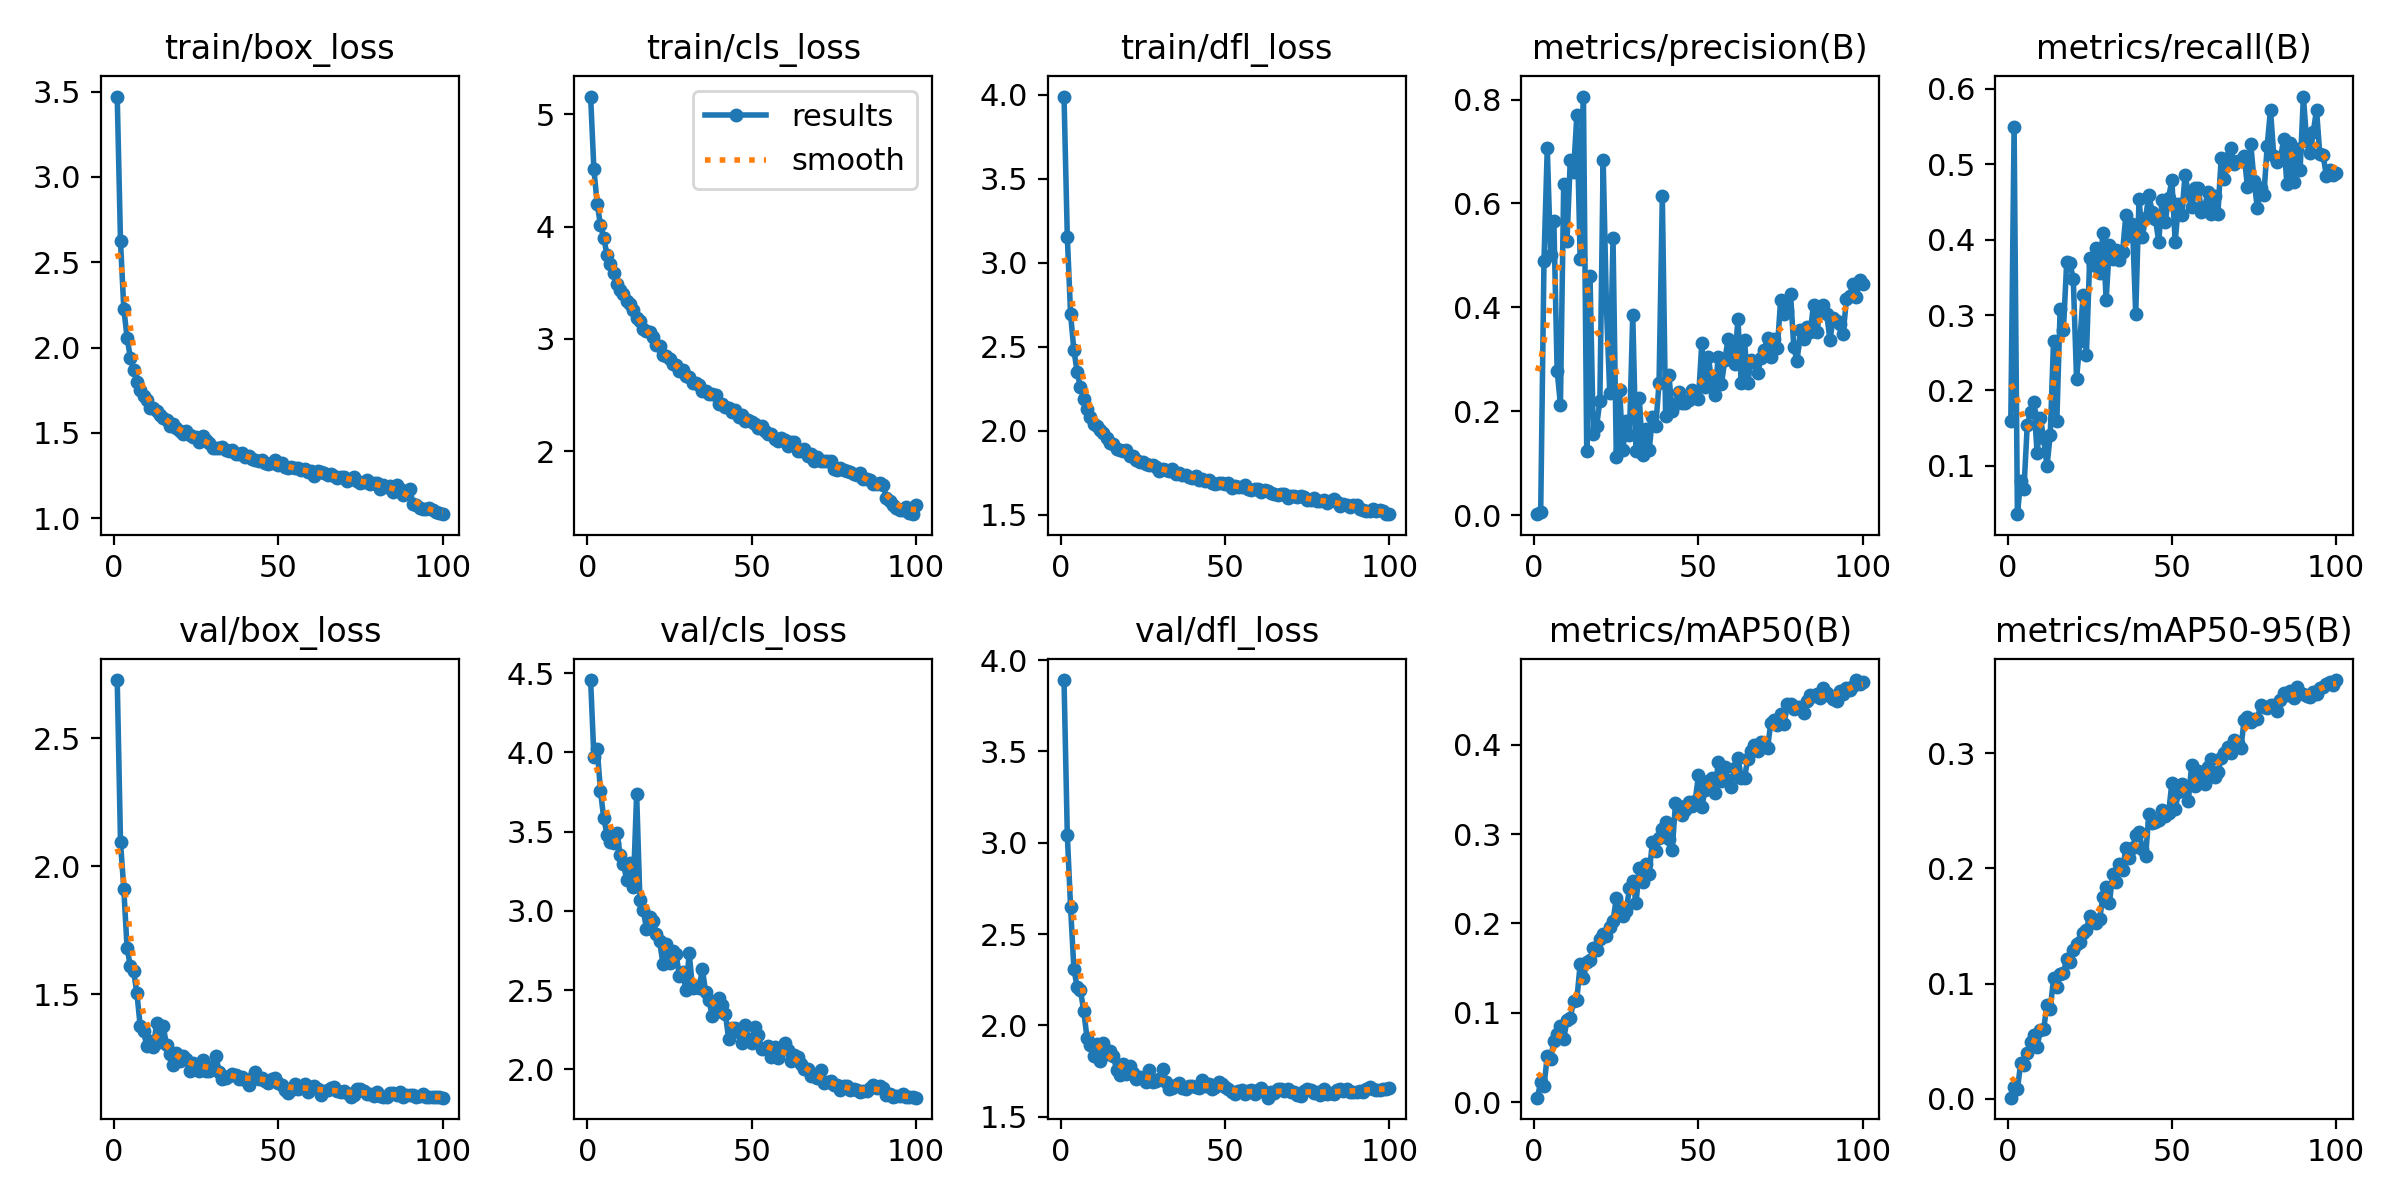

In [ ]:
Image(filename=f'/content/runs/detect/train5/results.png')

In [ ]:
model = YOLO("/content/runs/detect/train3/weights/best.pt")